Import the requsite libraries

In [1]:
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt

Define the locations of your observational data and the model output folders.

In [2]:
obs_data_location = 'utqiagvik_soil_temperature_observations.csv' #replace with your path
model_data_control_location = '/mnt/output/tem/tem_ee1_warming/control/' #replace with your path
model_data_treatment_location = '/mnt/output/tem/tem_ee1_warming/warming_2.6C_JJAS_2019/' #replace with your path

Define the function to extract monthly temperature data at a given depth

In [3]:
def monthly_T_data(depth, model_scenario):
    folder1= model_scenario+'output/'+'TLAYER_monthly_tr.nc'
    folder2= model_scenario+'output/'+'LAYERDZ_monthly_tr.nc'

    for folder, name in [(folder1, "temp"), (folder2, "layer")]:
        ds = xr.open_dataset(folder)
        df = ds.to_dataframe()
        df.reset_index(inplace=True)

        #select one gridcell (MAY REMOVE IF INPUT IS ONE CELL!!!)
        df = df[(df['x'] == 0)]
        df = df[(df['y'] == 0)]

        #drop x and y
        df = df.drop(['x', 'y'], axis=1)
        df['time'] = df['time'].astype(pd.StringDtype()).astype('|datetime64[ns]')

        if name == "temp":
            temp = df
        else:
            layer = df


    yearly = pd.concat([temp.set_index(['time', 'layer']), layer.set_index(['time', 'layer'])], axis=1).reset_index()
    yearly['depth'] = yearly.groupby('time')['LAYERDZ'].cumsum()
    yearly_short= yearly[yearly['depth']>depth]
    yearly_lowest_layer = yearly_short.loc[yearly_short.groupby('time')['layer'].idxmin()]

    return yearly_lowest_layer

Load and process model and observational data

In [4]:
#load and process model data
temp_control_model = monthly_T_data(0.1, model_data_control_location)
temp_treatment_model = monthly_T_data(0.1, model_data_treatment_location)

# load observational data
temp_obs = pd.read_csv(obs_data_location)
temp_obs['time'] = pd.to_datetime(temp_obs['TIMESTAMP'])
temp_obs = temp_obs.drop(columns=['TIMESTAMP'])

Create a comparision plot

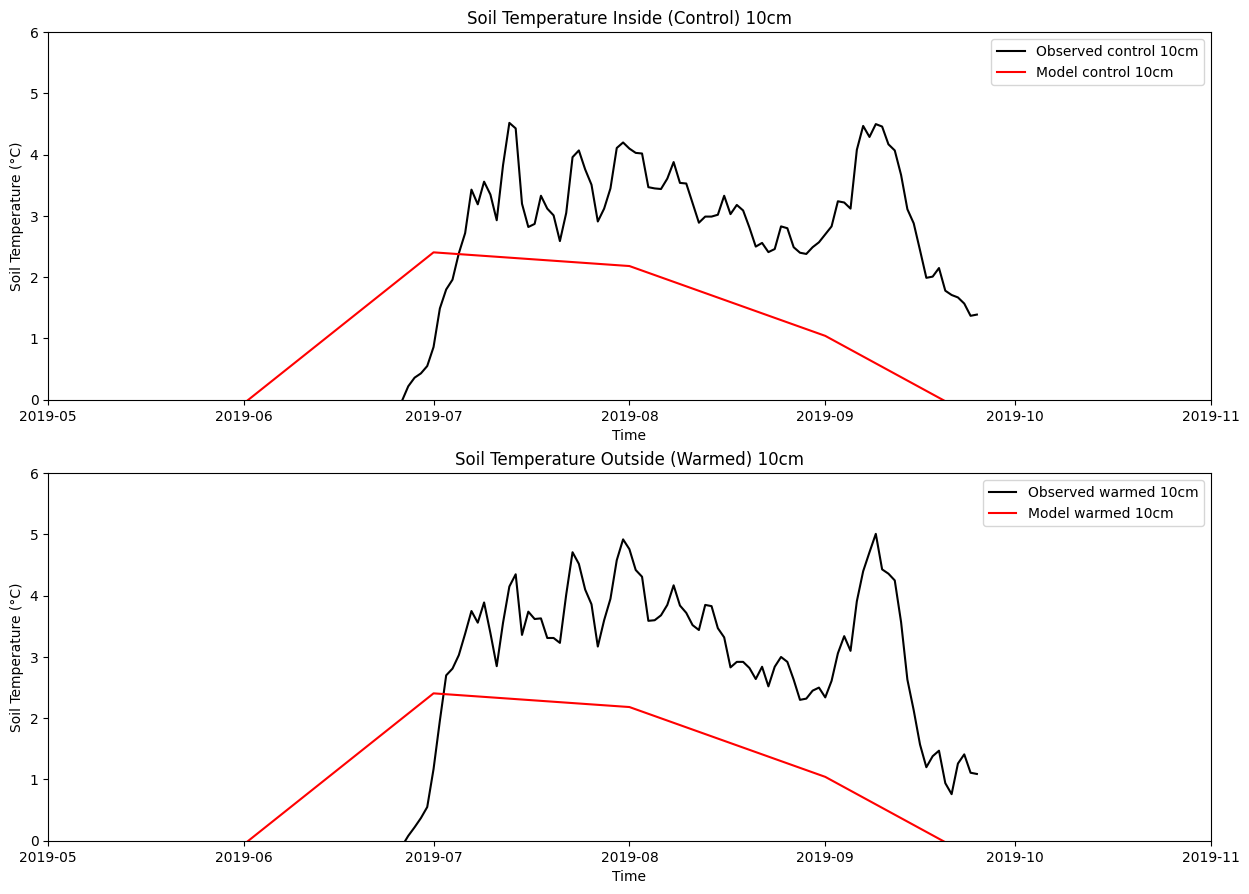

In [5]:
fig, ax = plt.subplots(2, 1, figsize=(15, 10.5))

ax1=ax[0]
ax2=ax[1]

#plot observed data
ax1.plot(temp_obs['time'], temp_obs['SoilTemp_Inside'], label='Observed control 10cm', color='black')
ax1.plot(temp_control_model['time'], temp_control_model['TLAYER'], label='Model control 10cm', color='red')

ax2.plot(temp_obs['time'], temp_obs['SoilTemp_Outside'], label='Observed warmed 10cm', color='black')
ax2.plot(temp_treatment_model['time'], temp_treatment_model['TLAYER'], label='Model warmed 10cm', color='red')


#add labels and legend
configs = [
    (ax1, 'Soil Temperature Inside (Control) 10cm'),
    (ax2, 'Soil Temperature Outside (Warmed) 10cm')
]

for ax, title in configs:
    ax.set_title(title)
    ax.set_xlabel('Time')
    ax.set_ylabel('Soil Temperature (°C)')
    ax.legend()
    ax.set_ylim(0, 6)
    ax.set_xlim(pd.to_datetime('2019-05-01'), pd.to_datetime('2019-11-01'))


plt.show()